### Libraries

In [59]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
import weakref
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report
from torch import nn
import torch.nn.functional as F
import types
from transformers.modeling_outputs import SemanticSegmenterOutput
from enum import Enum
from torchvision import transforms
import nibabel as nib
from pathlib import Path
import math
from collections import defaultdict
from medsyn.tasks import (
    CutPastePatchBlender,
    SmoothIntensityChangeTask,
    GaussIntensityChangeTask,
    SinkDeformationTask,
    SourceDeformationTask,
    IdentityTask,
)
from transformers import UperNetForSemanticSegmentation, AutoImageProcessor
from torchinfo import summary
import yaml
from easydict import EasyDict
import math
import argparse
import warnings
from utils.misc_helper import (
    AverageMeter,
    compute_imagewise_metrics,
    compute_pixelwise_metrics,
    get_current_time,
    create_logger,
    set_seed
)
from torch.utils.data import DataLoader
from utils.losses import FocalLoss, BinaryDiceLoss

import pprint
from tqdm import tqdm
import multiprocessing
import numpy as np
import random
from pathlib import Path
import json

In [60]:
import torch.utils.data as data
import json
import random
from PIL import Image
import numpy as np
from pathlib import Path
from collections import defaultdict

In [61]:
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, create_test_image_3d
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, ResNet
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.11.4
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.19.0
tqdm version: 4.66.4
lmdb version: 1.5.1
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.49.0
mlflow version: 2.15.0
pynrrd version: 1.0.0
clearml version: 1.16.3rc2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Original model

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [63]:
num_workers = max(1, multiprocessing.cpu_count() - 1)

In [64]:
model = UperNetForSemanticSegmentation.from_pretrained(
    "openmmlab/upernet-swin-base"
)

processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-base")

In [65]:
summary(model, input_size=(8, 3, 512, 512))  # (B,C,H,W)

Layer (type:depth-idx)                                            Output Shape              Param #
UperNetForSemanticSegmentation                                    [8, 150, 512, 512]        --
├─SwinBackbone: 1-1                                               [8, 128, 128, 128]        --
│    └─SwinEmbeddings: 2-1                                        [8, 16384, 128]           --
│    │    └─SwinPatchEmbeddings: 3-1                              [8, 16384, 128]           6,272
│    │    └─LayerNorm: 3-2                                        [8, 16384, 128]           256
│    │    └─Dropout: 3-3                                          [8, 16384, 128]           --
│    └─SwinEncoder: 2-2                                           [8, 128, 128, 128]        --
│    │    └─ModuleList: 3-4                                       --                        86,870,008
│    └─ModuleDict: 2-3                                            --                        --
│    │    └─LayerNorm: 3-5       

In [66]:
num_classes = 2

# Replace the final classifier
model.decode_head.classifier = nn.Conv2d(
    in_channels=model.decode_head.classifier.in_channels,
    out_channels=num_classes,
    kernel_size=1
)

#summary(model, input_size=(8, 3, 224, 224))

# REMEMBER: UperNetHead is the actual head, UperNetFCNHead is used only during training
# to check whether compression is working

In [67]:
def new_forward(self, pixel_values=None, output_hidden_states=None, return_dict=True, **kwargs):
    # get input shape
    input_shape = pixel_values.shape if pixel_values is not None else None
    # run backbone + head
    outputs = self.backbone(pixel_values)
    feats = outputs.feature_maps

    logits = self.decode_head(feats)


    # fix interpolation: only use H, W
    if input_shape is not None:
        h, w = input_shape[-2:]
        logits = F.interpolate(logits, size=(h, w),
                               mode="bilinear", align_corners=False)
    return SemanticSegmenterOutput(logits=logits)

model.forward = types.MethodType(new_forward, model)


In [68]:
img3d, mask3d = create_test_image_3d(64, 64, 64, num_seg_classes=2, channel_dim=0)

img3d = torch.tensor(img3d)   # [1, 64, 64, 64]
mask3d = torch.tensor(mask3d)

slice_idx = 32
img2d = img3d[0, slice_idx].unsqueeze(-1).repeat(1, 1, 3).numpy()  # duplicates the last dimension 3 times -> fake RGB
# because UPerNet expects a 3-channel RGB input

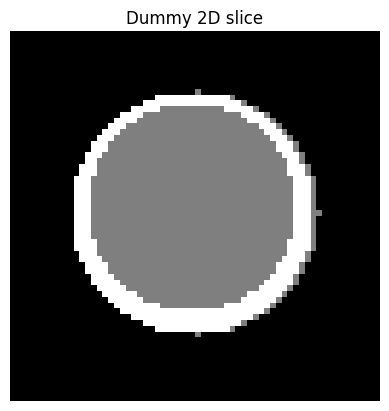

In [69]:
plt.imshow(img2d.astype("float32"), cmap="gray")  # or just plt.imshow(img2d) since it's RGB
plt.title("Dummy 2D slice")
plt.axis("off")
plt.show()

In [70]:
mask2d = mask3d[0, slice_idx].unsqueeze(-1).repeat(1, 1, 3).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


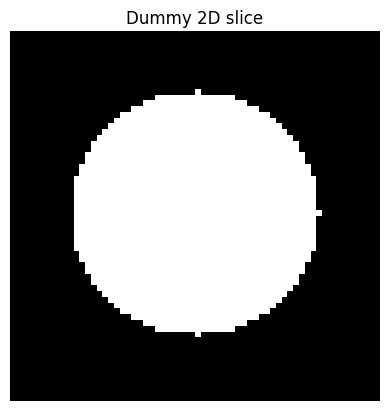

In [71]:
plt.imshow(mask2d.astype("float32"), cmap="gray")
plt.title("Dummy 2D slice")
plt.axis("off")
plt.show()

In [72]:
# pre-process into the tensor-shape and normalization that the model expects
inputs = processor(images=img2d, return_tensors="pt")

In [73]:
inputs['pixel_values'].shape

torch.Size([1, 3, 512, 512])

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs.to(device);

In [75]:
model.to(device)  # moves all params/buffers

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits  # [1, num_classes, H', W']

In [76]:
# 6. Resize back to original size
seg = processor.post_process_semantic_segmentation(outputs, target_sizes=[img2d.shape[:2]])
seg = seg[0].cpu().numpy()

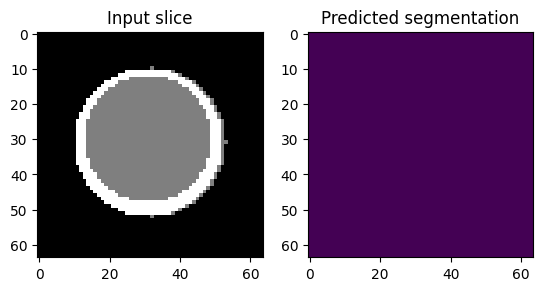

In [77]:
# 7. Visualize
plt.subplot(1,2,1)
plt.imshow(img2d); plt.title("Input slice")
plt.subplot(1,2,2)
plt.imshow(seg, cmap="viridis"); plt.title("Predicted segmentation")
plt.show()

In [78]:
# Access backbone
backbone = model.backbone  # this is SwinModel

# Access patch embedding
print(backbone.embeddings)

SwinEmbeddings(
  (patch_embeddings): SwinPatchEmbeddings(
    (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
)


In [79]:
conv2d = backbone.embeddings.patch_embeddings.projection
W2d = conv2d.weight.data
b2d = conv2d.bias.data

In [80]:
type(inputs)

transformers.image_processing_base.BatchFeature

### Modify to 3D input

In [81]:
def preprocess_3d_volume(volume, depth_size=5, stride=1, mean=None, std=None):
    """
    volume: torch.Tensor [C,D,H,W] or [D,H,W] if single-channel
    depth_size: number of slices per window
    stride: step along depth
    """
    if volume.ndim == 3:
        volume = volume.unsqueeze(0)  # [1,D,H,W]

    C, D, H, W = volume.shape
    windows = []
    for start in range(0, D - depth_size + 1, stride):
        clip = volume[:, start:start+depth_size, :, :]  # [C, depth_size, H, W]

        # normalize like processor (ImageNet mean/std per channel)
        if mean is not None and std is not None:
            for c in range(C):
                clip[c] = (clip[c] - mean[c]) / std[c]

        windows.append(clip)

    # [num_windows, C, depth_size, H, W]
    return torch.stack(windows)


In [82]:
vol = torch.randn(1, 20, 224, 224)  # [C=1, D=20, H,W]
windows = preprocess_3d_volume(vol, depth_size=5, stride=5)
print(windows.shape)  # [num_windows, 1, 5, 224, 224]
# non-overlapping windows due to stride = depth_size

torch.Size([4, 1, 5, 224, 224])


In [83]:
class Conv3dPatchEmbed(nn.Module):
    def __init__(self, in_chans=1, embed_dim=128,
                 kernel_size=(5,4,4), stride=(5,4,4), pretrained_weights = None, pretrained_bias = None):
        super().__init__()
        self.proj = nn.Conv3d(in_chans, embed_dim,
                              kernel_size=kernel_size,
                              stride=stride)
        # todo: add check for the dimensionality to match between pretrained_weights and these
        nn.init.zeros_(self.proj.weight)
        middle_layer = kernel_size[0] // 2
        self.proj.weight.data[:, 0, middle_layer, :, :] = pretrained_weights[:, 0, :, :] + pretrained_weights[:, 1, :, :] + pretrained_weights[:, 2, :, :]

        self.proj.bias.data = pretrained_bias.clone()


    def forward(self, x):                     # x: [B,C,D,H,W]
        x = self.proj(x)                      # [B,embed_dim,D',H',W']
        # IMPORTANT: UPerNet/Swin is 2D downstream. Ensure D'==1, then squeeze.
        if x.shape[2] != 1:
            raise ValueError(f"Depth after Conv3d must be 1 to squeeze, got {x.shape[2]}. "
                             "Fix kernel/stride/padding or handle 3D downstream.")
        x = x[:, :, 0, :, :]                  # [B,embed_dim,H',W']
        return x

In [84]:
def make_patch_embeddings_3d(embeddings: nn.Module, conv3d_embedder: nn.Module):
    # Create a weak reference (non-owning) to the parent embeddings object
    # This avoids circular references and ensures `embeddings` is not kept alive
    parent_ref = weakref.proxy(embeddings)

    # Access the original patch embedding layer from the parent (e.g., SwinEmbeddings.patch_embeddings)
    base = embeddings.patch_embeddings

    # Extract the patch_size attribute if it exists, otherwise default to (4,4)
    # Note: only primitives like tuples/ints are copied, not layers
    patch_size = getattr(base, "patch_size", (4,4))

    # Define a nested class to replace the original patch embedding with a 3D version
    class PatchEmbeddings3D(nn.Module):
        def __init__(self):
            super().__init__()
            # Register the custom 3D convolutional embedder (the actual learnable child module)
            self.conv3d = conv3d_embedder

            # Keep track of patch size as a primitive attribute (safe to copy)
            self.patch_size = patch_size

        def forward(self, pixel_values_5d: torch.Tensor):
            # Enforce 5D input: [Batch, Channels, Depth, Height, Width]
            if pixel_values_5d.ndim != 5:
                raise ValueError(f"Expected [B,C,D,H,W], got {tuple(pixel_values_5d.shape)}")

            # Apply the 3D convolution to produce embeddings
            # Output shape will be [B, C, H', W'] (depth collapsed by conv stride/kernel)
            x = self.conv3d(pixel_values_5d)
            B, C, H, W = x.shape

            # If the parent embeddings module has a normalization layer, apply it
            # Hugging Face convention: flatten spatial dims, apply LN(C), then reshape
            if getattr(parent_ref, "norm", None) is not None:
                x_flat = x.flatten(2).transpose(1, 2)   # [B, H'*W', C]
                x_flat = parent_ref.norm(x_flat)        # apply LayerNorm on channel dim
                # Optionally could reshape back to [B, C, H', W'], but here kept flattened
                x = x_flat

            # Return embeddings and the resulting spatial resolution (H', W')
            return x, (H, W)

    # Instantiate and return the new PatchEmbeddings3D module
    return PatchEmbeddings3D()


In [85]:
conv2d = model.backbone.embeddings.patch_embeddings.projection
W2d = conv2d.weight.data
b2d = conv2d.bias.data

In [86]:
conv3d_embed = Conv3dPatchEmbed(
    in_chans=1,
    embed_dim=128,         # must match Swin config
    kernel_size=(5,4,4),
    stride=(5,4,4),
    pretrained_weights=W2d,
    pretrained_bias=b2d
)

In [87]:
# Replace the entire patch_embeddings module with the 3D-aware wrapper
model.backbone.embeddings.patch_embeddings = make_patch_embeddings_3d(
    model.backbone.embeddings,
    conv3d_embed
)

In [88]:
model.backbone.embeddings

SwinEmbeddings(
  (patch_embeddings): PatchEmbeddings3D(
    (conv3d): Conv3dPatchEmbed(
      (proj): Conv3d(1, 128, kernel_size=(5, 4, 4), stride=(5, 4, 4))
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [89]:
# 4) Test
x = torch.randn(2, 1, 5, 224, 224).to(device)  # [B,C,D,H,W]; D=5 fits kernel=(5,...) with stride=(5,...)
model.to(device)
tokens, (H, W) = model.backbone.embeddings.patch_embeddings(x)
print(tokens.shape, (H, W))
# Expected: tokens -> [B, embed_dim, H', W'], (H', W') consistent with stride

torch.Size([2, 3136, 128]) (56, 56)


In [90]:
model.backbone.embeddings.patch_embeddings.conv3d.proj.weight[0]

tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0010,  0.0752, -0.1624, -0.2067],
          [ 0.0497,  0.2111,  0.0617,  0.1348],
          [-0.0512, -0.0140,  0.0711,  0.0239],
          [-0.1518, -0.0956, -0.0805,  0.0813]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]]], device='cuda:0',
       grad_

In [91]:
x = torch.randn(2, 1, 5, 224, 224).to(device)  # [B,C,D,H,W]
tokens, (H, W) = model.backbone.embeddings.patch_embeddings(x)
normalized_tokens = model.backbone.embeddings.norm(tokens)
dropout_tokens = model.backbone.embeddings.dropout(normalized_tokens)

In [92]:
class SwinEmbeddings3D(nn.Module):
    def __init__(self, patch_embeddings3d, embed_dim, p_drop=0.0):
        super().__init__()
        self.patch_embeddings = patch_embeddings3d     # your Conv3dPatchEmbed
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):                              # x: [B,C,D,H,W]
        if x.ndim != 5:
            raise ValueError(f"Expected 5D, got {x.shape}")
        tokens, (H, W) = self.patch_embeddings(x)   # tokens: [B, N, C], N=D*H*W
        tokens = self.norm(tokens)
        tokens = self.dropout(tokens)
        return tokens, (H, W)

emb3d = SwinEmbeddings3D(
    patch_embeddings3d=model.backbone.embeddings.patch_embeddings,  # your Conv3d block
    embed_dim=128,
    p_drop=0.0,
)
model.backbone.embeddings = emb3d

In [93]:
model.backbone.embeddings

SwinEmbeddings3D(
  (patch_embeddings): PatchEmbeddings3D(
    (conv3d): Conv3dPatchEmbed(
      (proj): Conv3d(1, 128, kernel_size=(5, 4, 4), stride=(5, 4, 4))
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [94]:
x = torch.randn(2, 1, 5, 224, 224).to(device)  # [B,C,D,H,W]
model.to(device)
embedded = model.backbone.embeddings(x) # where embedded[0] is the actual embeddings, embedded[1] is (#patches_x, #patches_y)

In [95]:
embedded[0].shape, embedded[1]

(torch.Size([2, 3136, 128]), (56, 56))

In [96]:
x = torch.randn(1, 1, 5, 512, 512).to(device)  # [B,C,D,H,W]
tokens, (H, W) = model.backbone.embeddings(x)  # embedding returns both

In [97]:
tokens.shape

torch.Size([1, 16384, 128])

In [98]:
print(tokens.shape, H , W)

torch.Size([1, 16384, 128]) 128 128


In [99]:
encoded = model.backbone.encoder(tokens, (H, W))

In [100]:
bb_out = model.backbone(pixel_values=x)     # ← correct entry point
feats = bb_out.feature_maps

In [101]:
len(feats)

4

In [102]:
model.decode_head

UperNetHead(
  (classifier): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
  (psp_modules): UperNetPyramidPoolingModule(
    (0): UperNetPyramidPoolingBlock(
      (0): AdaptiveAvgPool2d(output_size=1)
      (1): UperNetConvModule(
        (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
    )
    (1): UperNetPyramidPoolingBlock(
      (0): AdaptiveAvgPool2d(output_size=2)
      (1): UperNetConvModule(
        (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
    )
    (2): UperNetPyramidPoolingBlock(
      (0): AdaptiveAvgPool2d(output_size=3)
      (1): UperNetConvModule(
        (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
       

In [103]:
logits = model.decode_head(feats)
print(logits.shape)
logits = F.interpolate(logits, size=x.shape[-2:], mode="bilinear", align_corners=False)
print(logits.shape)

torch.Size([1, 2, 128, 128])
torch.Size([1, 2, 512, 512])


In [104]:
model.auxiliary_head

UperNetFCNHead(
  (convs): Sequential(
    (0): UperNetConvModule(
      (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
  )
  (classifier): Conv2d(256, 150, kernel_size=(1, 1), stride=(1, 1))
)

In [105]:
logits_aux = model.auxiliary_head(feats)

In [106]:
logits_aux.shape

torch.Size([1, 150, 32, 32])

### 2D dataset

In [ ]:
import os
os.environ["MONAI_DATA_DIRECTORY"] = "./2d_dataset"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [ ]:
set_determinism(seed = 0)

In [ ]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 34186
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 0, 10000, 4186, 0, 10000]


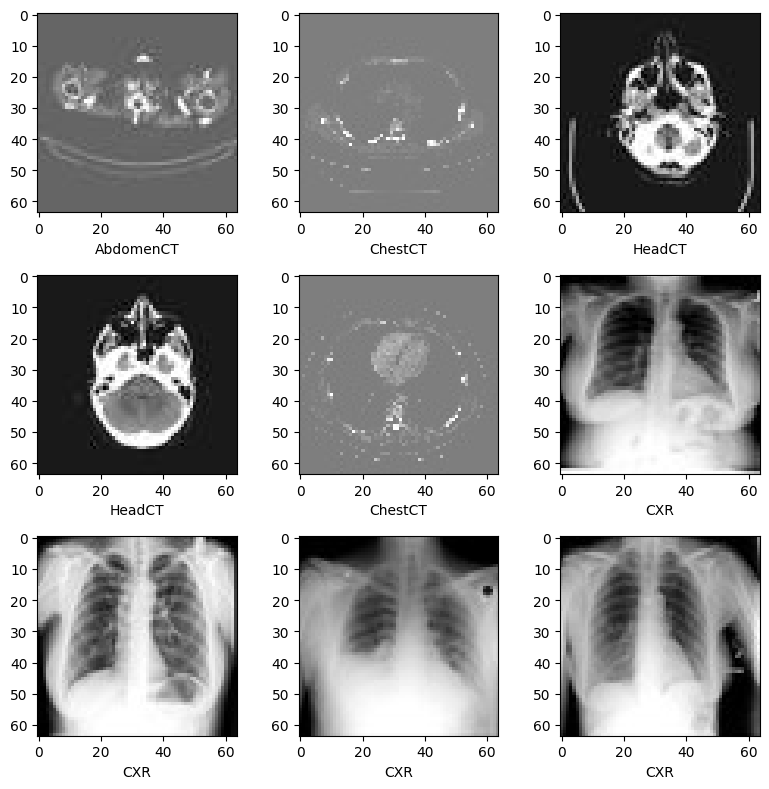

In [ ]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [ ]:
len(image_files_list)

34186

In [ ]:
reduced_list = image_files_list[:5]
reduced_class = image_class[:5]

In [ ]:
tensors = []
for path in reduced_list:
    img = Image.open(path).convert("L")          # or "RGB" depending on data
    arr = np.array(img, dtype=np.float32) / 255.0  # normalize to [0,1]
    t = torch.from_numpy(arr).unsqueeze(0)       # [1,H,W]
    t = t.repeat(3,1,1)                          # [3,H,W]
    tensors.append(t)

# stack into batch
reduced_list = torch.stack(tensors)  # [B,3,H,W]


In [ ]:
reduced_list.shape

torch.Size([5, 3, 64, 64])

In [ ]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels):
        self.image_files = image_files
        self.labels = labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.image_files[index], self.labels[index]


inference_ds = MedNISTDataset(reduced_list, reduced_class)
inference_loader = DataLoader(inference_ds, batch_size=300, shuffle=True, num_workers=10)

This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Il processo completo non funziona perchè, anche se non appare nella struttura, viene fatta un'interpolazione come ultimissimo passaggio per ritornare alla dimensionalità iniziale. Il problema è che se l'input sono 5 slice, e io ne predico una, allora sarà impossibile tornare in 3D

In [ ]:
inputs = processor(images = reduced_list, return_tensors='pt').to(device)

In [ ]:
inputs['pixel_values'].shape

torch.Size([5, 3, 512, 512])

In [ ]:
inputs['pixel_values'] = inputs['pixel_values'][:, 0, :, :].unsqueeze(1).permute(1,0,2,3)

In [ ]:
inputs['pixel_values'].shape

torch.Size([1, 5, 512, 512])

In [ ]:
inputs['pixel_values'] = inputs['pixel_values'].unsqueeze(1)

In [ ]:
inputs['pixel_values'].shape

torch.Size([1, 1, 5, 512, 512])

In [ ]:
bb_out = model.backbone(pixel_values=inputs['pixel_values'])     # ← correct entry point
feats = bb_out.feature_maps

In [ ]:
logits = model.decode_head(feats)
logits = F.interpolate(logits, size=x.shape[-2:], mode="bilinear", align_corners=False)

In [ ]:
logits.cpu()

tensor([[[[-0.1225, -0.1225, -0.1066,  ..., -0.0820, -0.0873, -0.0873],
          [-0.1225, -0.1225, -0.1066,  ..., -0.0820, -0.0873, -0.0873],
          [-0.1081, -0.1081, -0.0914,  ..., -0.0721, -0.0792, -0.0792],
          ...,
          [-0.0737, -0.0737, -0.0598,  ..., -0.0524, -0.0668, -0.0668],
          [-0.0815, -0.0815, -0.0676,  ..., -0.0787, -0.0931, -0.0931],
          [-0.0815, -0.0815, -0.0676,  ..., -0.0787, -0.0931, -0.0931]],

         [[ 0.0156,  0.0156,  0.0268,  ...,  0.0689,  0.0556,  0.0556],
          [ 0.0156,  0.0156,  0.0268,  ...,  0.0689,  0.0556,  0.0556],
          [ 0.0083,  0.0083,  0.0180,  ...,  0.0502,  0.0375,  0.0375],
          ...,
          [-0.0831, -0.0831, -0.0791,  ..., -0.0442, -0.0443, -0.0443],
          [-0.0998, -0.0998, -0.0955,  ..., -0.0487, -0.0465, -0.0465],
          [-0.0998, -0.0998, -0.0955,  ..., -0.0487, -0.0465, -0.0465]]]],
       grad_fn=<ToCopyBackward0>)

In [ ]:
logits[0].shape

torch.Size([2, 512, 512])

In [ ]:
logits[0].cpu();

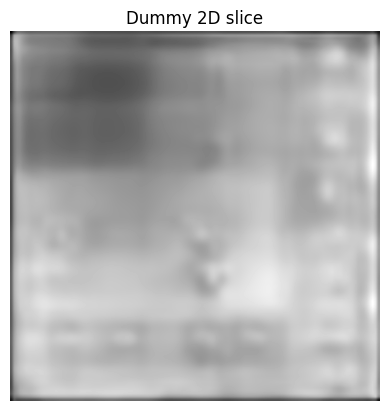

In [ ]:
plt.imshow(np.array(logits[0, 0, :, :].detach().cpu()), cmap="gray")
plt.title("Dummy 2D slice")
plt.axis("off")
plt.show()

### Normalization

In [107]:
"""
Windowed 3D preprocessing exactly like the paper:
- Build K-slice windows (e.g., K=5) along depth
- Apply ONE set of spatial augments jointly to all K slices
- CT normalization: clip [-175,250] -> scale to [-1,1]
- Return tensors shaped [B, 1, K, 512, 512] (B handled by DataLoader)
- Target is the CENTER slice mask only
"""

from typing import List, Tuple, Optional
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import random

# -----------------------
# Utility: normalization
# -----------------------
def normalize_ct_window(x: torch.Tensor, clip_min=-175.0, clip_max=250.0) -> torch.Tensor:
    """
    x: float tensor [K,H,W] (values in HU)
    -> clip to [clip_min, clip_max], map to [-1,1]
    """
    x = x.clamp_(clip_min, clip_max)
    x = (x - clip_min) / (clip_max - clip_min)  # [0,1]
    x = x * 2.0 - 1.0                           # [-1,1]
    return x

def normalize_mri_window(x: torch.Tensor) -> torch.Tensor:
    """
    x: float tensor [K,H,W] (non-negative)
    -> map [0, max] to [-1,1]

    
    Normalize MRI intensities to [-1, 1].

    Assumes non-negative input. Scales values relative to the maximum
    intensity found in the window.

    Args:
        x (torch.Tensor): Input tensor of shape [K, H, W] representing
            a stack of K slices from an MRI scan (float, non-negative).

    Returns:
        torch.Tensor: Normalized tensor with same shape [K, H, W],
        values in [-1, 1].
    """
    maxval = x.max().clamp(min=1e-6)
    x = x / maxval * 2.0 - 1.0
    return x

# -----------------------
# Utility: spatial ops (shared params for all K slices + center mask)
# -----------------------
def random_zoom_crop_pad(
    imgK: torch.Tensor,         # [K,H,W], float
    msk: Optional[torch.Tensor],# [H,W], long (center slice) or None
    out_hw=(512, 512),
    zoom_range=(0.5, 2.0),
    p_apply=1.0,
    rng: Optional[random.Random] = None,
):
    """
    Apply random zoom, crop, or pad to a K-slice image window (and optional mask).

    Procedure:
      - Sample a zoom factor z ~ U(zoom_range).
      - Resize image to (H*z, W*z).
      - If resized dims >= target out_hw: random crop to out_hw.
      - Else: pad to out_hw (zeros for image, 0 for mask).

    Args:
        imgK (torch.Tensor): Tensor of shape [K, H, W], float, image slices.
        msk (Optional[torch.Tensor]): Center-slice mask [H, W] or None.
        out_hw (tuple): Target (H, W) output size. Default (512, 512).
        zoom_range (tuple): Range (min_zoom, max_zoom). Default (0.5, 2.0).
        p_apply (float): Probability of applying random zoom. Otherwise, only resize. Default 1.0.
        rng (Optional[random.Random]): RNG instance. Default: Python `random`.

    Returns:
        Tuple[torch.Tensor, Optional[torch.Tensor]]:
            - Image tensor [K, out_H, out_W]
            - Mask tensor [out_H, out_W] or None
    """
    if rng is None:
        rng = random

    H, W = imgK.shape[-2:]
    if rng.random() > p_apply:
        # Only resize to out size (deterministic path)
        imgK = TF.resize(imgK, out_hw, interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
        if msk is not None:
            msk = TF.resize(msk.unsqueeze(0).float(), out_hw, interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()
        return imgK, msk

    z = rng.uniform(*zoom_range)
    newH, newW = max(1, int(round(H * z))), max(1, int(round(W * z)))
    # Resize images (bilinear) and mask (nearest)
    imgK = TF.resize(imgK, (newH, newW), interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
    if msk is not None:
        msk = TF.resize(msk.unsqueeze(0).float(), (newH, newW), interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()

    outH, outW = out_hw
    if newH >= outH and newW >= outW:
        # Random crop
        i = rng.randint(0, newH - outH)
        j = rng.randint(0, newW - outW)
        imgK = imgK[:, i:i+outH, j:j+outW]
        if msk is not None:
            msk = msk[i:i+outH, j:j+outW]
    else:
        # Pad to out size
        pad_top = (outH - newH) // 2 if newH < outH else 0
        pad_bottom = outH - newH - pad_top if newH < outH else 0
        pad_left = (outW - newW) // 2 if newW < outW else 0
        pad_right = outW - newW - pad_left if newW < outW else 0
        # Pad order for F.pad is (left, right, top, bottom)
        imgK = F.pad(imgK, (pad_left, pad_right, pad_top, pad_bottom), mode="constant", value=0.0)
        if msk is not None:
            msk = F.pad(msk, (pad_left, pad_right, pad_top, pad_bottom), mode="constant", value=0)

    return imgK, msk

def random_flip_rotate(
    imgK: torch.Tensor,          # [K,H,W]
    msk: Optional[torch.Tensor], # [H,W]
    p_flip=0.1,
    p_rot=0.1,
    max_degrees=10.0,
    rng: Optional[random.Random] = None,
):
    """
    Apply random horizontal/vertical flips and small rotations.

    Args:
        imgK (torch.Tensor): Tensor of shape [K, H, W], float, image slices.
        msk (Optional[torch.Tensor]): Center-slice mask [1, H, W] or None.
        p_flip (float): Probability of applying horizontal/vertical flip. Default 0.1.
        p_rot (float): Probability of applying rotation. Default 0.1.
        max_degrees (float): Maximum rotation angle in degrees. Default 10.0.
        rng (Optional[random.Random]): RNG instance. Default: Python `random`.

    Returns:
        Tuple[torch.Tensor, Optional[torch.Tensor]]:
            - Flipped/rotated image [K, H, W]
            - Flipped/rotated mask [H, W] or None
    """
    if rng is None:
        rng = random

    # Horizontal flip
    if rng.random() < p_flip:
        imgK = TF.hflip(imgK)
        if msk is not None:
            msk = TF.hflip(msk)

    # Vertical flip
    if rng.random() < p_flip:
        imgK = TF.vflip(imgK)
        if msk is not None:
            msk = TF.vflip(msk)

    # Small rotation
    if rng.random() < p_rot:
        angle = rng.uniform(-max_degrees, max_degrees)
        imgK = TF.rotate(imgK, angle=angle, interpolation=TF.InterpolationMode.BILINEAR, fill=0.0)
        if msk is not None:
            msk = TF.rotate(msk.unsqueeze(0), angle=angle, interpolation=TF.InterpolationMode.NEAREST, fill=0).squeeze(0)
    return imgK, msk

def random_intensity_shift(
    imgK: torch.Tensor,  # [K,H,W], in [-1,1]
    p=0.5,
    magnitude=0.1,
    rng: Optional[random.Random] = None,
):
    """
    Apply random additive intensity shift to [-1, 1]-normalized image window.

    Args:
        imgK (torch.Tensor): Input tensor [K, H, W], float, values in [-1, 1].
        p (float): Probability of applying shift. Default 0.5.
        magnitude (float): Maximum absolute shift. Default 0.1.
        rng (Optional[random.Random]): RNG instance. Default: Python `random`.

    Returns:
        torch.Tensor: Shifted tensor, clamped back to [-1, 1].
    """
    if rng is None:
        rng = random
    if rng.random() < p:
        delta = rng.uniform(-magnitude, magnitude)
        imgK = (imgK + delta).clamp_(-1.0, 1.0)
    return imgK


In [108]:
# -----------------------
# Dataset
# -----------------------
class Windowed3DSegDataset(Dataset):
    """
    volumes[i] : numpy array [D,H,W], floats (CT HU or MRI intensity)
    masks[i]   : numpy array [D,H,W], ints in {0..C-1} (center-slice target)
    Returns:
      image: torch.FloatTensor [1, K, 512, 512]
      mask:  torch.LongTensor  [512, 512]  (center slice)
    """
    def __init__(
        self,
        volumes: List[np.ndarray],
        masks:   List[np.ndarray],
        modality: str = "MRI",       # "CT" or "MRI"
        K: int = 5,
        stride: int = 1,
        out_hw: Tuple[int,int] = (512,512),
        augment: bool = True,
        seed: Optional[int] = None,
    ):
        assert len(volumes) == len(masks)
        assert K % 2 == 1, "K must be odd (so there is a center slice)."
        self.vols  = volumes
        self.masks = masks
        self.modality = modality.upper()
        self.K = K
        self.halfK = K // 2
        self.stride = stride
        self.out_hw = out_hw
        self.augment = augment
        self.rng = random.Random(seed) if seed is not None else random

        # Precompute (volume_index, center_index) pairs
        self.index = []
        for vi, vol in enumerate(self.vols):
            D = vol.shape[0]
            # centers from halfK .. D-1-halfK inclusive
            centers = range(self.halfK, D - self.halfK, self.stride)
            for c in centers:
                self.index.append((vi, c))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        vi, c = self.index[idx]
        vol = self.vols[vi]   # [D,H,W], np
        msk = self.masks[vi]  # [D,H,W], np

        # Extract K-slice window centered at c
        win = vol[c - self.halfK : c + self.halfK + 1]     # [K,H,W]
        cen = msk[c]                                       # [H,W]

        # To torch
        win_t = torch.from_numpy(win).float()              # [K,H,W]
        cen_t = torch.from_numpy(cen).long()               # [H,W]

        # Shared spatial transforms
        if self.augment:
            win_t, cen_t = random_zoom_crop_pad(win_t, cen_t, out_hw=self.out_hw, rng=self.rng)
            win_t, cen_t = random_flip_rotate(win_t, cen_t, rng=self.rng)
        else:
            # Deterministic resize only
            win_t = TF.resize(win_t, self.out_hw, interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
            cen_t = TF.resize(cen_t.unsqueeze(0).float(), self.out_hw, interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()

        # Intensity normalization
        if self.modality == "CT":
            win_t = normalize_ct_window(win_t)
        else:
            win_t = normalize_mri_window(win_t)

        # Optional intensity jitter
        if self.augment:
            win_t = random_intensity_shift(win_t, rng=self.rng)

        # Stack to [1,K,H,W] for 3D patch-embed
        win_t = win_t.unsqueeze(0)  # [1,K,H,W] (C=1)
        print(f"win t shape is {win_t.shape}")
        return {
            "image": win_t,          # float32, [-1,1]
            "mask":  cen_t,          # long, center slice labels
            "center_idx": c,
            "volume_idx": vi,
        }

In [109]:
# -----------------------
# Example usage
# -----------------------
if __name__ == "__main__":
    # Dummy demo data (replace with real volumes/masks)
    # Suppose each volume is [D=60, H=400, W=400]
    N = 3
    vols = [np.random.normal(0, 300, size=(60, 400, 400)).astype(np.float32) for _ in range(N)]  # pretend CT HU
    msks = [np.random.randint(0, 4, size=(60, 400, 400), dtype=np.int16) for _ in range(N)]      # 4 classes

    ds = Windowed3DSegDataset(
        volumes=vols,
        masks=msks,
        modality="MRI",
        K=5,
        stride=1,
        out_hw=(512, 512),
        augment=True,
        seed=1337,
    )

    dl = DataLoader(ds, batch_size=2, shuffle=True, num_workers=0)

    batch = next(iter(dl))
    x = batch["image"]  # [B, 1, K, 512, 512]
    y = batch["mask"]   # [B, 512, 512]

    print("image:", x.shape, x.dtype, x.min().item(), x.max().item())
    print("mask: ", y.shape, y.dtype, y.min().item(), y.max().item())

    # >>> image: torch.Size([2, 1, 5, 512, 512]) torch.float32 -1.0 1.0
    # >>> mask:  torch.Size([2, 512, 512]) torch.int64 0 3

win t shape is torch.Size([1, 5, 512, 512])
win t shape is torch.Size([1, 5, 512, 512])
image: torch.Size([2, 1, 5, 512, 512]) torch.float32 -2.878286600112915 1.0
mask:  torch.Size([2, 512, 512]) torch.int64 0 3


### BEiT

In [ ]:
from transformers import BeitModel, SwinModel, AutoModel

In [ ]:
enc = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")
# BEiT encoder's weights from ImageNet-22k

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

In [ ]:
enc

BeitModel(
  (embeddings): BeitEmbeddings(
    (patch_embeddings): BeitPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BeitEncoder(
    (layer): ModuleList(
      (0): BeitLayer(
        (attention): BeitAttention(
          (attention): BeitSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=False)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (relative_position_bias): BeitRelativePositionBias()
          )
          (output): BeitSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): BeitIntermediate(
          (dense): Linear(in_features=768, out_fea

In [ ]:
from transformers import BeitConfig, UperNetConfig, UperNetForSemanticSegmentation

beit_backbone = BeitConfig(
    output_hidden_states=True,
    out_indices=[2, 5, 8, 11]   # can be tweaked
)
cfg = UperNetConfig(backbone_config=beit_backbone, num_labels=2)
model = UperNetForSemanticSegmentation(cfg)
# decoder's weights RANDOMLY INITIALIZED

In [ ]:
model

UperNetForSemanticSegmentation(
  (backbone): BeitBackbone(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): BeitIntermediate(
            (dense): L

### Dataset

In [116]:
from typing import Dict, List, Any

def sample_per_slice(data_to_iterate: Dict[Any, List[Any]], k_shot: int) -> List[Any]:
    """
    Randomly samples `k_shot` elements from each list of values contained in a dictionary.

    For every key in `data_to_iterate`, this function draws `k_shot` random, non-repeating
    samples from the list associated with that key and concatenates all samples into a
    single output list. If any list contains fewer than `k_shot` elements, a ValueError
    is raised.

    Parameters
    ----------
    data_to_iterate : dict[Any, list[Any]]
        A dictionary where each key maps to a list (or iterable) of sampleable elements.
    k_shot : int
        Number of elements to randomly sample from each list.

    Returns
    -------
    list[Any]
        A flattened list containing all sampled elements across all keys.

    Raises
    ------
    ValueError
        If any list under a given key has fewer than `k_shot` elements.
    """
    all_samples: List[Any] = []
    for key in data_to_iterate.keys():
        values = data_to_iterate[key]
        if len(values) < k_shot:
            raise ValueError(f"Not enough elements to sample {k_shot} from key {key}")
        all_samples.extend(random.sample(values, k_shot))
    return all_samples

In [ ]:
class BratsDataset(data.Dataset):
    def __init__(
            self, 
            args, 
            root,
            transform,
            target_transform,
            mode='test',
            save_dir='fewshot',
            k_shot=0,
            seed=None,
    ):
        self.args = args
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        self.__image_path_key = (
            "img_path" if args.train_dataset == "brats-met" else "filename"
        )
        meta_info = self._get_meta_info(mode, k_shot)
        self.data_all = self._load_slices(meta_info, mode, save_dir, k_shot)

        self.length = len(self.data_all)

        self.rng = random.Random(seed) if seed is not None else random

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img_paths = self.data_all[
            index
        ]  # data_all is a list of dictionaries for each sample
        images = []

        counter = 0
        for img_path in img_paths:
            if self.args.train_dataset != 'brats-met':
                img_path = os.path.join(self.root, "images", img_path)
            # the index has no relation with the slice number

            image = self.read_image(img_path)
            image = Image.fromarray(image.astype(np.uint8)).convert("RGB")

            if counter == 2:
                mask_path = img_path.replace("t2w", "seg")
                mask = self.read_mask(mask_path)
                middle_mask = torch.from_numpy(mask)

                """plt.figure(figsize=(4, 4))
                plt.imshow(middle_mask.cpu().numpy(), cmap='gray', interpolation='nearest')
                plt.title(f"mask max={middle_mask.max().item()} min={middle_mask.min().item()}")
                plt.axis("off")
                plt.tight_layout()
                plt.show(block=False)
                plt.pause(0.001)"""
                    
            images.append(image)
            counter += 1

        images = self.transform(images = images, return_tensors='pt')
        images['pixel_values'] = images['pixel_values'][:, 0, :, :] # exp. shape [D, H, W]

        if self.mode != 'test':
            win_t, cen_t = random_zoom_crop_pad(images['pixel_values'], middle_mask, out_hw=(512, 512), rng=self.rng)
            win_t, cen_t = random_flip_rotate(win_t, cen_t, rng=self.rng)
        else:
            # Deterministic resize only
            win_t = TF.resize(images['pixel_values'], (512, 512), interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
            cen_t = TF.resize(middle_mask.unsqueeze(0).float(), (512, 512), interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()

        win_t = normalize_mri_window(win_t) # assuming we only have MRIs and not CTs

        # Optional intensity jitter
        if self.mode != 'test':
            win_t = random_intensity_shift(win_t, rng=self.rng)

        # Stack to [1,K,H,W] for 3D patch-embed
        images['pixel_values'] = win_t.unsqueeze(0)  # [1,K,H,W] (C=1)
        # TODO: check why in the augment we don't consider the random zoom & rotate
        return {"images": images, "mask": cen_t}


    def _get_meta_info(self, mode, k_shot):
        if self.args.train_dataset == "brats-met":
            # ? how to intend random sample for patients:
            # option 1 - shuffle the dictionary and take the first K healthy slice
            # option 2 - take all ith healthy slices and select K out of them
            # I prefer option 2 since it's easier 
            meta_info = json.load(open(f"{self.root}/meta.json", "r"))
            data_to_iterate = defaultdict(list)
            # iterate through patients
            current_depth = []
            for i, slice in enumerate(meta_info[mode]['brain']):
                # iterate through slices of a patient
                id = i % 155 # i is in [0, 154*#patients] and id in [0, 154]
                if id < 120 and id >= 80: # exclude 120 otherwise we get a single slice
                    if id % self.args.distance_per_slice == 0 and i > 0:
                        #if current_depth[2].get('anomaly')==0:
                        if len(current_depth)>0: data_to_iterate[id].append(current_depth)
                        current_depth = [slice]
                    else:
                        current_depth.append(slice)
                #data_to_iterate.append(value[str(slice_idx).zfill(3)])
            # todo: not the most elegant solution
            #for key, value in data_to_iterate.items():
            #   print(f"key {key} has {len(value)} samples")
            if mode == 'train':
                data_to_iterate = sample_per_slice(data_to_iterate, k_shot)
            else:
                data_to_iterate = [item for values in data_to_iterate.values() for item in values]
        else:
            data_to_iterate = []
            with open(os.path.join(self.root, "samples", f"{mode}.json"), "r") as f_r:
                for line in f_r:
                    meta = json.loads(line)
                    data_to_iterate.append(meta)
            if k_shot != -1:
                data_to_iterate = random.sample(data_to_iterate, k_shot)

        return data_to_iterate
    
    def _get_cls_names(self, save_dir):
        # TODO: check in MediCLIP if we want to have more classes (e.g., edema, tumor core, enhancing tumor)
        cls_names = ["brain"]
        Path(save_dir).mkdir(exist_ok=True)
        save_dir = os.path.join(save_dir, "k_shot.txt")
        
        return cls_names, save_dir
    
    def _load_slices(self, meta_info, mode, save_dir, k_shot):
        self.cls_names, save_dir = self._get_cls_names(save_dir)
        data_all = []
        for cls_name in self.cls_names:
            # Clean the file before writing
            with open(save_dir, "w"): pass
            for images in meta_info:
                image_path_keys = []
                for image in images:
                    # image_path = {self.__image_path_key: image[self.__image_path_key]}
                    image_path_keys.append(image[self.__image_path_key])
                    with open(save_dir, "a") as f:  
                        # Write the image path of the selected samples to a file
                        f.write(image[self.__image_path_key] + "\n")
                        # This creates a file with the paths of the selected samples, useful for reproducibility
                
                data_all.append(image_path_keys)
        return data_all
    
    def read_image(self, path):
        image = (
            Image.open(path)
            .resize(
                (self.args.image_size, self.args.image_size), Image.Resampling.BILINEAR
            )
            .convert("L")
        )
    
        image = np.array(image).astype(np.uint8) 
        return image
    
    def read_mask(self, path):
        
        mask = (
            Image.open(path)
            .resize(
                (self.args.image_size, self.args.image_size), Image.Resampling.NEAREST
            )
            .convert("L")
        )
        mask = np.array(mask)
        mask = (mask > 100).astype(np.int64)
        return mask


### Previous dataset

In [ ]:
class TrainDataset(data.Dataset):
    def __init__(
        self,
        args,
        root,
        transform,
        target_transform,
        mode="test",
        save_dir="fewshot",
        k_shot=0,
    ):
        self.args = args
        self.root = root
        #self.transform = transforms.ToTensor() #! remove this transform once we go back to the original
        #self.transform = transform #!
        self.transform = processor
        self.target_transform = target_transform
        self.__image_path_key = (
            "img_path" if args.train_dataset == "brats-met" else "filename"
        )
        meta_info = self._get_meta_info(mode, k_shot)

        self.data_all = self._load_slices(meta_info, mode, save_dir, k_shot)
        self.augs, self.augs_pro = self.load_anomaly_syn()
        assert sum(self.augs_pro) == 1.0
        self.length = len(self.data_all)
        
    
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img_paths = self.data_all[
            index
        ]  # data_all is a list of dictionaries for each sample
        images = []
        masks = []

        counter = 0

        choice_aug = np.random.choice(
                a=[aug for aug in self.augs],
                p=[pro for pro in self.augs_pro],
                size=(1,),
                replace=False,
            )
        choice_aug = choice_aug[0]
        for img_path in img_paths:
            if self.args.train_dataset != 'brats-met':
                img_path = os.path.join(self.root, "images", img_path)
            # the index has no relation with the slice number

            image = self.read_image(img_path)

            # During traning we apply the augmentation to the image, hence we don't care about the original mask
            # Augmentation applied EACH time the item is retrieved
        
            image, mask = choice_aug(image)
            
            image = Image.fromarray(image.astype(np.uint8)).convert("RGB")
            
            #image = self.transform(image)
            # ? normalization
            if counter == 2:
                middle_mask = torch.from_numpy(mask)

            images.append(image)
            counter += 1

        images = self.transform(images = images, return_tensors='pt')
        images['pixel_values'] = images['pixel_values'][:, 0, :, :].unsqueeze(1).permute(1,0,2,3)
        return {"images": images, "mask": middle_mask}


    def _get_meta_info(self, mode, k_shot):
        if self.args.train_dataset == "brats-met":
            # ? how to intend random sample for patients:
            # option 1 - shuffle the dictionary and take the first K healthy slice
            # option 2 - take all ith healthy slices and select K out of them
            # I prefer option 2 since it's easier 
            meta_info = json.load(open(f"{self.root}/meta.json", "r"))
            data_to_iterate = defaultdict(list)
            # iterate through patients
            current_depth = []
            for i, slice in enumerate(meta_info['train']['brain']):
                # iterate through slices of a patient
                id = i % 155
                    
                if id % self.args.distance_per_slice == 0 and i > 0:
                    #if current_depth[2].get('anomaly')==0:
                        # ! since the model has been trained as a semantic segmentation, AND we are using a loss
                        # that compares the output to the mask and not to the image itself (hence not a reconstruction)
                        # we might end up in a trivial solution where the classification layer has only 0s weights
                        # ! however we apply an augmentation that results in 75% anomalous images 
                    data_to_iterate[id].append(current_depth)
                        
                    current_depth = [slice]
                else:
                    current_depth.append(slice)
                #data_to_iterate.append(value[str(slice_idx).zfill(3)])
            if k_shot != -1: 
                data_to_iterate = sample_per_slice(data_to_iterate, k_shot)
            # Filter out anomaly slices for few-shot learning
            #meta_info = filter_data(data_to_iterate)  
        else:
            data_to_iterate = []
            with open(os.path.join(self.root, "samples", "train.json"), "r") as f_r:
                for line in f_r:
                    meta = json.loads(line)
                    data_to_iterate.append(meta)
            if k_shot != -1:
                data_to_iterate = random.sample(data_to_iterate, k_shot)

        return data_to_iterate

    def _get_cls_names(self, meta_info, mode, save_dir):
        if mode == "train":
            cls_names = ["brain"]
            Path(save_dir).mkdir(exist_ok=True)
            save_dir = os.path.join(save_dir, "k_shot.txt")
        else:
            cls_names = list(
                meta_info.keys()
            )  # During testing all available classes from the metadata are used
            # This allows the model to be evaluated across all anatomical regions in the dataset
        return cls_names, save_dir

    def _load_slices(self, meta_info, mode, save_dir, k_shot):
        self.cls_names, save_dir = self._get_cls_names(meta_info, mode, save_dir)
        data_all = []
        for cls_name in self.cls_names:
            if mode == "train":
                # Clean the file before writing
                with open(save_dir, "w"): pass
                for images in meta_info:
                    image_path_keys = []
                    for image in images:
                        # image_path = {self.__image_path_key: image[self.__image_path_key]}
                        image_path_keys.append(image[self.__image_path_key])
                        with open(save_dir, "a") as f:  
                            # Write the image path of the selected samples to a file
                            f.write(image[self.__image_path_key] + "\n")
                            # This creates a file with the paths of the selected samples, useful for reproducibility
                    
                    data_all.append(image_path_keys)
                    
            # ! must be updated     
            else:
                # TODO: data_all is now a list of img_paths and not dictionaries
                data_all.extend(
                    meta_info[cls_name]
                )  # for testing, all samples are used
        return data_all

    def read_image(self, path):
        image = (
            Image.open(path)
            .resize(
                (self.args.image_size, self.args.image_size), Image.Resampling.BILINEAR
            )
            .convert("L")
        )
        image = np.array(image).astype(np.uint8)
        return image

    def load_anomaly_syn(self):
        tasks = []
        task_probability = []
        for task_name in self.args.anomaly_tasks.keys():
            if task_name == "CutpasteTask":
                support_images = [
                    self.read_image(os.path.join(self.root, "images", data[2])) 
                    for data in self.data_all 
                ]
                task = CutPastePatchBlender(support_images)
            elif task_name == "SmoothIntensityTask":
                task = SmoothIntensityChangeTask(30.0)
            elif task_name == "GaussIntensityChangeTask":
                task = GaussIntensityChangeTask()
            elif task_name == "SinkTask":
                task = SinkDeformationTask()
            elif task_name == "SourceTask":
                task = SourceDeformationTask()
            elif task_name == "IdentityTask":
                task = IdentityTask()
            else:
                raise NotImplementedError(
                    "task must in [CutpasteTask, "
                    "SmoothIntensityTask, "
                    "GaussIntensityChangeTask,"
                    "SinkTask, SourceTask, IdentityTask]"
                )

            tasks.append(task)
            task_probability.append(self.args.anomaly_tasks[task_name])
        return tasks, task_probability


### BratsMetTestDataset

In [ ]:
class BratsMetTestDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        args,
        source,
        preprocess,
        slice_idx,
        left_idx=0,
        right_idx=0,
        **kwargs,
    ):
        super().__init__()
        self.args = args
        self.source = source
        self.transform_img = preprocess
        self.slice_idx = slice_idx
        self.left_idx = left_idx
        self.right_idx = right_idx
        self.data_to_iterate = self.get_image_data()

    def __getitem__(self, idx):
        info = self.data_to_iterate[idx] 
        # eg: {'filename': 'Testing/BraTS-MET-00415-000', 'label': 1, 'label_name': 'abnormal', 'clsname': 'abnormal', 'slice': 150}

        if self.slice_idx == -1:
            #image_path = os.path.join(self.source, info["filename"], 't2w', str(info['slice']).zfill(3)+'.jpeg')  
            #mask_path = os.path.join(self.source, info["filename"], 'seg', str(info['slice']).zfill(3)+'.jpeg')
            image_path = info['img_path']
            mask_path = info['mask_path']
        else:
            image_path = os.path.join(self.source, info["filename"], 't2w', str(self.slice_idx).zfill(3)+'.jpeg')    
            mask_path = os.path.join(self.source, info["filename"], 'seg', str(self.slice_idx).zfill(3)+'.jpeg')

        image = (
            PIL.Image.open(image_path)
            .convert("RGB")
            .resize(
                (self.args.image_size, self.args.image_size),
                PIL.Image.Resampling.BILINEAR,
            )
        )
        if os.path.exists(mask_path):
            mask = (
                PIL.Image.open(mask_path)
                .convert("L")
                .resize(
                    (self.args.image_size, self.args.image_size),
                    PIL.Image.Resampling.NEAREST,
                )
            )
            mask = np.array(mask).astype(float) / 255.0
            mask[mask != 0.0] = 1.0
        else:
            mask = np.zeros((self.args.image_size, self.args.image_size), dtype=float)

        image = self.transform_img(image)
        mask = torch.from_numpy(mask)
        
        return {
            "image": image,
            "mask": mask,
            #"classname": 'abnormal' if num_ones > 10 else 'normal', # ? why we had it in first place
            #"is_anomaly": 1 if num_ones > 10 else 0, # computed directly from the mask
            #"image_path": str(image_path), # ? shouldnt need it since we pass the image 
        }

    def __len__(self):
        return len(self.data_to_iterate)

    def get_image_data(self):
        data_to_iterate = []

        meta_info = json.load(open(f"{self.source}/meta.json", "r"))
            # iterate through patients
            
        if self.right_idx>0:
            for row in meta_info['test']['brain']:
            #for row in data:
                slice = int(row['img_path'].split('/')[-1].split('.')[0])
                #if slice >= self.left_idx and slice < self.right_idx:
                if slice >= self.left_idx and slice < self.right_idx:
                    row['slice'] = slice
                    data_to_iterate.append(row.copy())
        else:
            for row in data[:10]:
                if self.slice_idx == -1:
                    for slice in range(0, 155, int(self.args.distance_per_slice)):
                        row['slice'] = slice
                        data_to_iterate.append(row.copy())
                else:
                    data_to_iterate.append(row)

        return data_to_iterate
        

### train_one_epoch

In [118]:
def train_one_epoch(
    args,
    train_dataloader,
    optimizer,
    epoch,
    start_iter,
    logger,
    model,
    scheduler,
):
    loss_meter = AverageMeter(args.config.print_freq_step)
    # ! check if the original model predicts logits or probabilities 
    focal_criterion = FocalLoss()
    dice_criterion = BinaryDiceLoss()
    for i, input in enumerate(train_dataloader):

        curr_step = start_iter + i
        if curr_step >= args.config.total_steps:
            break
        
        images = input["images"].to(model.device) # [16, 1, 5, 512, 512]
        gt_mask = input["mask"].to(model.device).long()

        #print(f"images shape is {images['pixel_values'].shape}")
        #print(f"gt mask shape is {gt_mask.shape}")
        #1, 1, 5, 512, 512

        #with torch.no_grad(): 
        # ! don't run inference mode nowhere, since the gradient has to reach the beginning
        # instead torch.no_grad() cuts the gradient path in the place it's applied
        bb_out = model.backbone(pixel_values=images['pixel_values'])     # ← correct entry point
        feats = bb_out.feature_maps
        logits = model.decode_head(feats)
        logits_up = F.interpolate(logits, size=gt_mask.shape[-2:], mode="bilinear", align_corners=False)
        anomaly_map = torch.softmax(logits_up, dim=1)
        
        loss_list = []
        # S_n and S_a have shapes [B, H, W]
        # then anomaly_map has shape [B, 2, H, W] where [0] is S_n and [1] is S_a
        """function applies a softmax across the class dimension (dim=1) to turn 
        the [B, 2, H, W] into probabilities per class per pixel.
        Then, for each pixel:
            It extracts the probability for the true class (using gt_mask)
        """
        # at the beginning the weights are around 0, hence the model almost always predicts 0
        # since a mask is almost all 0s, the error is already low
        # build losses for this batch
        loss_list.append(dice_criterion(anomaly_map[:, 1, :, :], gt_mask))
        """Unlike Focal Loss or CrossEntropyLoss, which operate on probabilities 
        (and therefore penalize over- or under-confidence), Dice Loss works on 
        soft masks and is focused on overlap between prediction and ground truth.
        It doesn't care that much about the confidence:
            - In CrossEntropy/Focal Loss, confidence hugely change the loss depending 
            on how close they are to the target (e.g., log(0.95) vs log(0.55) is very different).
            - In Dice Loss, it just gets multiplied by the ground truth and added up
        """
        
        # e.g., focal on logits (or add your other terms)
        loss_list.append(focal_criterion(anomaly_map, gt_mask))
        # reduce to a single scalar tensor (preserves graph)
        loss = torch.stack(loss_list).sum()
        # backward + step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step() # must be called after optimizer.step() to update the lr correctly

        # logging (safe: don't overwrite `loss`)
        loss_meter.update(loss.detach().item())

        if curr_step % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Step {curr_step}: LR = {current_lr:.6f}")

        if (curr_step + 1) % args.config.print_freq_step == 0:
            logger.info(
                "Epoch: [{0}/{1}]\t"
                "Iter: [{2}/{3}]\t"
                "Loss {loss.val:.5f} ({loss.avg:.5f})\t".format(
                    epoch + 1,
                    args.config.epoch,
                    curr_step + 1,
                    len(train_dataloader) * args.config.epoch if len(train_dataloader) * args.config.epoch < args.config.total_steps else args.config.total_steps,
                    loss=loss_meter,
                )
            )

### validate

In [119]:
def validate(
    args, test_dataloaders, epoch, model, # TODO: check in MediCLIP how args and epoch were utilized
):
    results = {}
    for test_dataset_name in test_dataloaders:
        test_dataloader = test_dataloaders[test_dataset_name]
        anomaly_maps = []
        anomaly_gts = []

        image_scores = []
        image_labels = []

        with torch.no_grad():
            for i, input in enumerate(tqdm(test_dataloader, desc=test_dataset_name)):
                images = input["image"].to(model.device)
                anomaly_gt = input["mask"].to(model.device).long()

                bb_out = model.backbone(pixel_values=images['pixel_values'])
                feats = bb_out.feature_maps
                logits = model.decode_head(feats)
                logits_up = F.interpolate(logits, size=anomaly_gt.shape[-2:], mode="bilinear", align_corners=False)
                anomaly_map = torch.softmax(logits_up, dim=1)

                B, _, H, W = anomaly_map.shape

                anomaly_map = anomaly_map[:, 1, :, :]
                
                anomaly_maps.append(anomaly_map.cpu().numpy())
                anomaly_gts.append(anomaly_gt.cpu().numpy())

                anomaly_scores, _ = torch.max(anomaly_map.view((B, H * W)), dim=-1)

                image_scores.extend(anomaly_scores.cpu().numpy().tolist())
                 
                #image_labels.extend(input["is_anomaly"].cpu().numpy().tolist())
                for mask in anomaly_gt:
                    num_ones = (mask == 1).sum().item()
                    image_labels.append(1 if num_ones > 10 else 0)

        metric = compute_imagewise_metrics(image_scores, image_labels)
        metric.update(compute_pixelwise_metrics(anomaly_maps, anomaly_gts))
        results[test_dataset_name] = metric

    return results

### main

In [151]:
def main(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    with open(args.config_path) as f:
        args.config = EasyDict(yaml.load(f, Loader=yaml.FullLoader))

    set_seed(seed=args.config.random_seed)

    source = os.path.join(args.config.data_root, args.config.train_dataset)
    
    train_dataset = BratsDataset(
        args=args.config,
        root=source,
        mode="train",
        target_transform=None, # TODO: check if should be applied
        transform=processor,
        k_shot=args.k_shot,
    )

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=args.config.batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    # TODO: use only a part of the test-set for inference
    test_dataset = BratsDataset(
        args=args.config,
        root=source,
        mode='test',
        target_transform=None,
        transform=processor,
    )

    test_dataloader = DataLoader(
            test_dataset, 
            batch_size=args.config.batch_size, 
            shuffle=False,
            num_workers=num_workers,
    )

    return

    test_dataloaders = {}
    best_record = {}

    test_dataloaders[test_dataset_name] = test_dataloader
    best_record[test_dataset_name] = None


    for param in model.parameters():
        param.requires_grad = False

    for param in model.decode_head.classifier.parameters():
        param.requires_grad = True

    for param in model.backbone.embeddings.patch_embeddings.conv3d.proj.parameters():
        param.requires_grad = True

    optimizer = torch.optim.AdamW(
        [
            {'params': model.decode_head.classifier.parameters(),
            'lr': float(args.config.learning_rate),
            'weight_decay': float(args.config.weight_decay)},

            {'params': model.backbone.embeddings.patch_embeddings.conv3d.proj.parameters(),
            'lr': float(args.config.learning_rate),
            'weight_decay': float(args.config.weight_decay)},
        ],
        betas=(0.9, 0.999) # how much to keep of the past gradients
    )

    def slanted_triangular_lr(step):
        if step < args.config.warmup_steps:
            return step / args.config.warmup_steps
        else:
            return max(0.0, (args.config.total_steps - step) / (args.config.total_steps - args.config.warmup_steps))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=slanted_triangular_lr)

    logger = create_logger("logger", os.path.join(args.config.save_root, "logger.log"))

    for epoch in range(0, args.config.epoch):

        last_iter = epoch * len(train_dataloader)

        if last_iter >= args.config.total_steps: break
        
        train_one_epoch(
            args,
            train_dataloader,
            optimizer,
            epoch,
            last_iter,
            logger,
            model,
            scheduler,
        )

        if (epoch+1) % args.config.val_freq_epoch == 0:
            results = validate(
                args,
                test_dataloaders,
                epoch,
                model,
            )
            save_flag = False

            for test_dataset_name in results:
                if best_record[test_dataset_name] is None:
                    best_record[test_dataset_name] = [
                        results[test_dataset_name]["image-auroc"],
                        results[test_dataset_name]["pixel-auroc"],
                    ]
                    
                    save_flag = True
                else:
                    if np.mean(
                        [
                            results[test_dataset_name][key]
                            for key in results[test_dataset_name]
                        ]
                    ) > np.mean(best_record[test_dataset_name]):

                        best_record[test_dataset_name] = [
                            results[test_dataset_name]["image-auroc"],
                            results[test_dataset_name]["pixel-auroc"],
                        ]
                        
                        save_flag = True

                logger.info(
                    "({}): Epoch: {}, image auroc: {:.4f}, pixel_auroc: {:.4f},".format(
                        test_dataset_name,
                        epoch + 1,
                        results[test_dataset_name]["image-auroc"],
                        results[test_dataset_name]["pixel-auroc"],
                    )
                )
                

            for test_dataset_name in results:
                logger.info(
                    "({} best): image auroc: {:.4f}, pixel auroc: {:.4f},".format(
                        test_dataset_name,
                        best_record[test_dataset_name][0],
                        best_record[test_dataset_name][1],
                    )
                )
               
    """
    TODO: save only the trainable params 
                if save_flag:
                    logger.info("save checkpoints in epoch: {}".format(epoch + 1))
                    torch.save(
                        {
                            "adapter_state_dict": adapter.state_dict(),
                            "prompt_state_dict": prompt_maker.prompt_learner.state_dict(),
                        },
                        os.path.join(
                            args.config.save_root, "checkpoints_{}.pkl".format(epoch + 1)
                        ),
                    )
    """

### long main

In [ ]:
def main(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    with open(args.config_path) as f:
        args.config = EasyDict(yaml.load(f, Loader=yaml.FullLoader))

    set_seed(seed=args.config.random_seed)

    model, preprocess, model_cfg = open_clip.create_model_and_transforms(
        args.config.model_name, args.config.image_size, device=device
    )

    if args.pmc:
        print('Using PMC')
        model_path = '/home/aldo_marzullo/.cache/huggingface/hub/models--ryanyip7777--pmc_vit_l_14/snapshots/a1db5a40d0a07855a435d9fabde846fdf7028be4/open_clip_pytorch_model.bin'
        model.load_state_dict(torch.load(model_path, weights_only=True))

    for param in model.parameters():
        param.requires_grad_(False)

    args.config.model_cfg = model_cfg

    make_vision_takens_info(model, args.config.model_cfg, args.config.layers_out)

    current_time = get_current_time()
    args.config.save_root = os.path.join(args.config.save_root, current_time)

    if not os.path.exists(args.config.save_root):
        os.makedirs(args.config.save_root)

    logger = create_logger("logger", os.path.join(args.config.save_root, "logger.log"))
    #logger.info("config: {}".format(pprint.pformat(args)))

    necker = Necker(clip_model=model).to(model.device)
    adapter = Adapter(clip_model=model, target=args.config.model_cfg["embed_dim"]).to(
        model.device
    )

    if args.config.prompt_maker == "coop":
        from models.CoOp import PromptMaker

        logger.info("load CoOp")
    else:
        raise NotImplementedError("type of prompt must in ['coop']")

    prompt_maker = PromptMaker(
        prompts=args.config.prompts,
        clip_model=model,
        n_ctx=args.config.n_learnable_token,
        CSC=args.config.CSC,
        class_token_position=args.config.class_token_positions,
    ).to(model.device)

    map_maker = MapMaker(image_size=args.config.image_size).to(model.device)

    if args.checkpoint_path:
        checkpoints = torch.load(
            args.checkpoint_path, map_location=str(device)
        )  # Pass device as string
        adapter.load_state_dict(checkpoints["adapter_state_dict"])
        prompt_maker.prompt_learner.load_state_dict(checkpoints["prompt_state_dict"])

    optimizer = torch.optim.Adam(
        [
            {"params": prompt_maker.prompt_learner.parameters(), "lr": 0.001},
            {"params": adapter.parameters(), "lr": 0.001},
        ],
        lr=0.001,
        betas=(0.5, 0.999),
    )

    source = os.path.join(args.config.data_root, args.config.train_dataset)
    if args.patients:
        assert args.config.train_dataset == "brats-met", (
            "patients training supported only for brats-met dataset"
        )
        train_dataset = TrainDatasetFewShot(
            args=args.config,
            root=source,
            mode="train",
            target_transform=None,
            transform=preprocess,
            k_shot=args.k_shot,
        )
    else:
        train_dataset = TrainDataset(
            args=args.config,
            root=source,
            mode="train",
            target_transform=None,
            transform=preprocess,
            k_shot=args.k_shot,
        )

    num_workers = max(1, multiprocessing.cpu_count() - 1)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=args.config.batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    test_dataloaders = {}
    best_record = {}

    for test_dataset_name in args.config.test_datasets:
        if test_dataset_name == "chexpert":
            test_dataset = ChexpertTestDataset(
                args=args.config,
                source=os.path.join(
                    args.config.data_root, test_dataset_name
                ),  # args.config.data_root = 'data' always
                preprocess=preprocess,
            )

        elif test_dataset_name == "brainmri":
            test_dataset = BrainMRITestDataset(
                args=args.config,
                source=os.path.join(args.config.data_root, test_dataset_name),
                preprocess=preprocess,
            )
        elif test_dataset_name == "busi":
            test_dataset = BusiTestDataset(
                args=args.config,
                source=os.path.join(args.config.data_root, test_dataset_name),
                preprocess=preprocess,
            )
        elif test_dataset_name == "brats-met":
            test_dataset = BratsMetTestDataset(
                args=args.config,
                source=os.path.join(args.config.data_root, test_dataset_name),
                preprocess=preprocess,
                slice_idx=-1,
            )
        else:
            raise NotImplementedError(
                "dataset must in ['chexpert','busi','brainmri', 'brats-met'] "
            )

        test_dataloader = DataLoader(
            test_dataset, batch_size=args.config.batch_size, num_workers=2
        )

        test_dataloaders[test_dataset_name] = test_dataloader

        best_record[test_dataset_name] = None

    logger.info(
        "train data ({}) len {}".format(args.config.train_dataset, len(train_dataset))
    )

    for test_dataset_name in test_dataloaders:
        logger.info(
            "test data ({}) len {}".format(
                test_dataset_name, len(test_dataloaders[test_dataset_name].dataset)
            )
        )

    for task_name in args.config.anomaly_tasks:
        logger.info(
            "anomaly syn task is {}, sampling probability is {}".format(
                task_name, args.config.anomaly_tasks[task_name]
            )
        )

    for epoch in range(0, args.config.epoch):
        last_iter = epoch * len(train_dataloader)
        
        train_one_epoch(
            args,
            train_dataloader,
            optimizer,
            epoch,
            last_iter,
            logger,
            model,
            necker,
            adapter,
            prompt_maker,
            map_maker,
        )
        
        if (epoch+1) % args.config.val_freq_epoch == 0:
            results = validate(
                args,
                test_dataloaders,
                epoch,
                model,
                necker,
                adapter,
                prompt_maker,
                map_maker,
            )
            save_flag = False

            for test_dataset_name in results:
                if best_record[test_dataset_name] is None:
                    if test_dataset_name == "busi" or test_dataset_name == "brats-met":
                        best_record[test_dataset_name] = [
                            results[test_dataset_name]["image-auroc"],
                            results[test_dataset_name]["pixel-auroc"],
                        ]
                    else:
                        best_record[test_dataset_name] = [
                            results[test_dataset_name]["image-auroc"]
                        ]

                    save_flag = True
                else:
                    if np.mean(
                        [
                            results[test_dataset_name][key]
                            for key in results[test_dataset_name]
                        ]
                    ) > np.mean(best_record[test_dataset_name]):
                        if (
                            test_dataset_name == "busi"
                            or test_dataset_name == "brats-met"
                        ):
                            best_record[test_dataset_name] = [
                                results[test_dataset_name]["image-auroc"],
                                results[test_dataset_name]["pixel-auroc"],
                            ]
                        else:
                            best_record[test_dataset_name] = [
                                results[test_dataset_name]["image-auroc"]
                            ]
                        save_flag = True

                if test_dataset_name == "busi" or test_dataset_name == "brats-met":
                    logger.info(
                        "({}): Epoch: {}, image auroc: {:.4f}, pixel_auroc: {:.4f},".format(
                            test_dataset_name,
                            epoch + 1,
                            results[test_dataset_name]["image-auroc"],
                            results[test_dataset_name]["pixel-auroc"],
                        )
                    )
                else:
                    logger.info(
                        "({}): Epoch: {}, image auroc: {:.4f},".format(
                            test_dataset_name,
                            epoch + 1,
                            results[test_dataset_name]["image-auroc"],
                        )
                    )

            for test_dataset_name in results:
                if test_dataset_name == "busi" or test_dataset_name == "brats-met":
                    logger.info(
                        "({} best): image auroc: {:.4f}, pixel auroc: {:.4f},".format(
                            test_dataset_name,
                            best_record[test_dataset_name][0],
                            best_record[test_dataset_name][1],
                        )
                    )
                else:
                    logger.info(
                        "({} best): image auroc: {:.4f},".format(
                            test_dataset_name,
                            best_record[test_dataset_name][0],
                        )
                    )

            if save_flag:
                logger.info("save checkpoints in epoch: {}".format(epoch + 1))
                torch.save(
                    {
                        "adapter_state_dict": adapter.state_dict(),
                        "prompt_state_dict": prompt_maker.prompt_learner.state_dict(),
                    },
                    os.path.join(
                        args.config.save_root, "checkpoints_{}.pkl".format(epoch + 1)
                    ),
                )


### call main

In [130]:
import gc, torch
gc.collect()                     # free Python refs
torch.cuda.empty_cache()         # release cached blocks to the driver
torch.cuda.ipc_collect()         # collect inter-process memory (if any)

In [131]:
import torch

device = torch.device("cuda:0")

allocated = torch.cuda.memory_allocated(device) / 1024**2  # in MB
reserved  = torch.cuda.memory_reserved(device)  / 1024**2

print(f"CUDA memory allocated: {allocated:.2f} MB")
print(f"CUDA memory reserved:  {reserved:.2f} MB")


CUDA memory allocated: 4380.30 MB
CUDA memory reserved:  10646.00 MB


In [63]:
print(torch.cuda.memory_summary(device=None, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 3            |        cudaMalloc retries: 3         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  14038 MiB |  14038 MiB |  93570 MiB |  79531 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  14038 MiB |  14038 MiB |  93570 MiB |  79531 MiB |
|---------------------------------------------------------------------------|
| Requested memory      |  13997 MiB |  13997 MiB |  93341 MiB |  79344 MiB |
|---------------------------------------------------------------

In [125]:
num_classes = 2

# Replace the final classifier
model.decode_head.classifier = nn.Conv2d(
    in_channels=model.decode_head.classifier.in_channels,
    out_channels=num_classes,
    kernel_size=1
)

model.to(device);

### call main

In [154]:
from torchvision import transforms
# TODO: check that effectively the masks are rotated/flipped the same way as the images
parser = argparse.ArgumentParser(description="Train MediCLIP")
parser.add_argument(
    "--config_path", type=str, default="config/brats-met.yaml", help="model configs"
)
parser.add_argument("--k_shot", type=int, default=16, help="normal image number")
parser.add_argument(
    "--patients",
    type=bool,
    default=False,
    help="whether to k-shot refers to patients",
)
parser.add_argument("--checkpoint_path", type=str, help="the checkpoint path", default=None)
parser.add_argument('--pmc', type=bool, help = 'use pmc as backbone', default=True) 
args, unknown = parser.parse_known_args()
#torch.multiprocessing.set_start_method("spawn")
main(args)

[[{'img_path': '/home/aldo_marzullo/data/BraTS2D/Training/BraTS-MET-00025-000/t2w/080.jpeg', 'cls_name': 'brain', 'mask_path': '/home/aldo_marzullo/data/BraTS2D/Training/BraTS-MET-00025-000/seg/080.jpeg', 'specie_name': 'no', 'anomaly': 1}, {'img_path': '/home/aldo_marzullo/data/BraTS2D/Training/BraTS-MET-00025-000/t2w/081.jpeg', 'cls_name': 'brain', 'mask_path': '/home/aldo_marzullo/data/BraTS2D/Training/BraTS-MET-00025-000/seg/081.jpeg', 'specie_name': 'no', 'anomaly': 1}, {'img_path': '/home/aldo_marzullo/data/BraTS2D/Training/BraTS-MET-00025-000/t2w/082.jpeg', 'cls_name': 'brain', 'mask_path': '/home/aldo_marzullo/data/BraTS2D/Training/BraTS-MET-00025-000/seg/082.jpeg', 'specie_name': 'no', 'anomaly': 1}, {'img_path': '/home/aldo_marzullo/data/BraTS2D/Training/BraTS-MET-00025-000/t2w/083.jpeg', 'cls_name': 'brain', 'mask_path': '/home/aldo_marzullo/data/BraTS2D/Training/BraTS-MET-00025-000/seg/083.jpeg', 'specie_name': 'no', 'anomaly': 1}, {'img_path': '/home/aldo_marzullo/data/Bra

In [64]:
model.backbone.embeddings.patch_embeddings.conv3d.proj.weight[0]

tensor([[[[-9.6449e-04, -8.5846e-04, -7.2895e-04, -6.1190e-04],
          [-8.4322e-04, -7.4155e-04, -6.2767e-04, -5.2980e-04],
          [-6.9477e-04, -6.1260e-04, -5.2506e-04, -4.5346e-04],
          [-5.4408e-04, -4.8931e-04, -4.3255e-04, -3.9146e-04]],

         [[-1.0542e-03, -9.4490e-04, -7.9456e-04, -6.5688e-04],
          [-9.3042e-04, -8.3462e-04, -7.0599e-04, -5.9068e-04],
          [-7.5637e-04, -6.8763e-04, -6.0168e-04, -5.1984e-04],
          [-5.6981e-04, -5.3189e-04, -4.8548e-04, -4.4395e-04]],

         [[-1.2341e-04,  7.4085e-02, -1.6320e-01, -2.0738e-01],
          [ 4.8682e-02,  2.1005e-01,  6.0865e-02,  1.3400e-01],
          [-5.2013e-02, -1.4785e-02,  7.0382e-02,  2.3266e-02],
          [-1.5237e-01, -9.6134e-02, -8.1013e-02,  8.0687e-02]],

         [[-1.1887e-03, -1.0861e-03, -9.5675e-04, -8.3879e-04],
          [-1.0732e-03, -9.8109e-04, -8.7019e-04, -7.7291e-04],
          [-9.1849e-04, -8.5185e-04, -7.7070e-04, -7.0422e-04],
          [-7.4043e-04, -7.0801e-0

In [65]:
model.decode_head.classifier.weight[0]

tensor([[[-3.3739e-02]],

        [[-4.3809e-03]],

        [[-1.1898e-02]],

        [[-1.9358e-02]],

        [[ 2.8991e-02]],

        [[ 5.9442e-03]],

        [[-7.4905e-03]],

        [[ 3.8400e-02]],

        [[-4.2460e-02]],

        [[-1.5411e-02]],

        [[-9.0779e-03]],

        [[ 1.1558e-02]],

        [[ 7.2276e-03]],

        [[ 3.8502e-02]],

        [[ 4.3938e-02]],

        [[ 1.7864e-02]],

        [[ 3.1310e-02]],

        [[-7.7630e-03]],

        [[ 2.9862e-02]],

        [[-3.3574e-02]],

        [[ 3.3535e-02]],

        [[-1.3603e-02]],

        [[-3.2718e-02]],

        [[-1.1794e-02]],

        [[ 3.7822e-02]],

        [[-2.5309e-02]],

        [[ 3.0665e-02]],

        [[ 2.4237e-03]],

        [[ 2.4195e-02]],

        [[ 4.3563e-03]],

        [[ 4.2491e-02]],

        [[ 2.0114e-02]],

        [[ 3.7406e-02]],

        [[-4.4580e-03]],

        [[ 4.2134e-02]],

        [[ 2.9742e-02]],

        [[ 1.4529e-02]],

        [[-1.1318e-02]],

        [[-1